# Statistics of the dataset

In [ ]:
import pandas as pd
import numpy as np
import psycopg2
from psycopg2 import extras

In [2]:
df = pd.read_csv('crypto_timeseries.csv')

In [3]:
df.describe()

,Date,Price,Open,High,Low,Vol.,Change %
count,156,156,156,156,156,156,156
unique,156,156,156,156,156,154,137
top,12/05/2025,"89,248.5","92,082.8","92,676.4","88,987.5",43.05K,-0.47%
freq,1,1,1,1,1,2,3


In [4]:
print("Dataset Statistics:")
print(f"Number of records: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"Missing values:\n{df.isnull().sum()}")

Dataset Statistics:
Number of records: 156
Columns: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
Missing values:
Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [5]:
print(df.head())

         Date     Price      Open      High       Low     Vol. Change %
0  12/05/2025  89,248.5  92,082.8  92,676.4  88,987.5   55.81K   -3.08%
1  12/04/2025  92,082.8  93,437.2  94,043.9  90,933.2   60.28K   -1.45%
2  12/03/2025  93,437.2  91,286.8  94,077.0  91,020.8   79.02K    2.35%
3  12/02/2025  91,287.6  86,315.2  92,285.4  86,189.8   87.36K    5.77%
4  12/01/2025  86,309.1  90,372.2  90,372.2  83,858.1  105.96K   -4.50%


In [6]:
print(df.dtypes)

Date        object
Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object


##XGBOOST

In [7]:
#Features creation for XGBOOST model

import pandas as pd
import numpy as np

def create_features_for_xgboost(df):
    # --- Step 0: Data Cleaning ---
    # Convert 'Date' to datetime objects and sort chronologically
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    
    # Clean 'Vol.' (e.g., "10K" -> 10000) and 'Change %' if they are strings
    if df['Vol.'].dtype == object:
        df['Vol.'] = df['Vol.'].replace({'K': '*1e3', 'M': '*1e6', 'B': '*1e9'}, regex=True).map(pd.eval).astype(float)
    if df['Change %'].dtype == object:
        df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

    # --- Step 1: Feature Engineering ---
    
    # 1. Log Returns
    # We use log returns because they are time-additive and more stable than raw prices
    df['log_ret'] = np.log(df['Price'] / df['Price'].shift(1))
    
    # 2. Lag Features (Memory)
    # What happened yesterday? (Lag 1)
    df['ret_lag1'] = df['log_ret'].shift(1)
    # What happened one week ago? (Lag 7 - captures weekly cycles)
    df['ret_lag7'] = df['log_ret'].shift(7)
    # Volume from yesterday (Volume often precedes price movement)
    df['vol_lag1'] = df['Vol.'].shift(1)
    
    # 3. Rolling Statistics (Trend & Volatility)
    # 30-day Moving Average (General monthly trend)
    df['ma_30'] = df['Price'].rolling(window=30).mean()
    
    # 30-day Standard Deviation (Is the market calm or chaotic?)
    df['std_30'] = df['log_ret'].rolling(window=30).std()
    
    # 4. Technical Indicators / Market Psychology
    # Distance from the Moving Average:
    # If positive/high -> Price is far above average (Potential bubble/overbought)
    # If negative/low -> Price is far below average (Potential oversold)
    df['dist_ma30'] = (df['Price'] / df['ma_30']) - 1
    
    # Daily Range: Normalized difference between High and Low
    # Shows intraday panic or euphoria
    df['daily_range'] = (df['High'] - df['Low']) / df['Price']

    # 5. Time Features
    # Crypto markets behave differently on weekends (Banks are closed)
    # 0 = Monday, 6 = Sunday
    df['day_of_week'] = df.index.dayofweek
    
    # --- Step 2: The Target ---
    # We want to predict the Price 7 days into the future.
    # On calcule la variation entre le prix dans 7 jours et le prix d'aujourd'hui
    df['target'] = np.log(df['Price'].shift(-7) / df['Price'])

    # Remove empty rows (NaNs) created by shifting and rolling
    df = df.dropna()
    
    return df

In [8]:
#Convert to float
df['Price'] = df['Price'].astype(str).str.replace(',', '').str.replace('$', '')
df['Price'] = df['Price'].astype(float)

df['High'] = df['High'].astype(str).str.replace(',', '').str.replace('$', '')
df['High'] = df['High'].astype(float)

df['Low'] = df['Low'].astype(str).str.replace(',', '').str.replace('$', '')
df['Low'] = df['Low'].astype(float)

df['Open'] = df['Open'].astype(str).str.replace(',', '').str.replace('$', '')
df['Open'] = df['Open'].astype(float)

df = create_features_for_xgboost(df)

In [9]:
df.head()

,Price,Open,High,Low,Vol.,Change %,log_ret,ret_lag1,ret_lag7,vol_lag1,ma_30,std_30,dist_ma30,daily_range,day_of_week,target
Date,,,,,,,,,,,,,,,,
2025-08-02,112547.7,113306.4,114050.0,112015.5,38340.0,-0.67,-0.006769,-0.021416,0.002426,77850.0,115909.646667,0.013469,-0.029005,0.018077,5,0.034270
2025-08-03,114213.1,112547.9,114758.4,111992.4,27150.0,1.48,0.014689,-0.006769,0.012477,38340.0,116117.096667,0.013360,-0.016397,0.024218,6,0.043466
2025-08-04,115055.3,114213.1,115720.9,114116.1,36550.0,0.74,0.007347,0.014689,-0.011322,27150.0,116345.450000,0.013397,-0.011089,0.013948,0,0.031099
2025-08-05,114139.1,115055.3,115111.7,112678.9,41410.0,-0.80,-0.007995,0.007347,-0.000880,36550.0,116509.853333,0.013448,-0.020348,0.021314,1,0.051291
2025-08-06,115002.1,114131.7,115714.0,113361.2,34730.0,0.76,0.007533,-0.007995,-0.000930,41410.0,116734.270000,0.013353,-0.014839,0.020459,2,0.069860


In [10]:
features_to_drop = ['target', 'Open', 'High', 'Low', 'Change %'] # On garde Price pour référence si besoin, sinon on l'enlève
X = df.drop(columns=features_to_drop)

# y = Ce qu'on veut prédire
y = df['target']

In [11]:
X.head()

,Price,Vol.,log_ret,ret_lag1,ret_lag7,vol_lag1,ma_30,std_30,dist_ma30,daily_range,day_of_week
Date,,,,,,,,,,,
2025-08-02,112547.7,38340.0,-0.006769,-0.021416,0.002426,77850.0,115909.646667,0.013469,-0.029005,0.018077,5
2025-08-03,114213.1,27150.0,0.014689,-0.006769,0.012477,38340.0,116117.096667,0.013360,-0.016397,0.024218,6
2025-08-04,115055.3,36550.0,0.007347,0.014689,-0.011322,27150.0,116345.450000,0.013397,-0.011089,0.013948,0
2025-08-05,114139.1,41410.0,-0.007995,0.007347,-0.000880,36550.0,116509.853333,0.013448,-0.020348,0.021314,1
2025-08-06,115002.1,34730.0,0.007533,-0.007995,-0.000930,41410.0,116734.270000,0.013353,-0.014839,0.020459,2


In [12]:
print(y)

Date
2025-08-02    0.034270
2025-08-03    0.043466
2025-08-04    0.031099
2025-08-05    0.051291
2025-08-06    0.069860
                ...   
2025-11-24   -0.022765
2025-11-25    0.043900
2025-11-26    0.031978
2025-11-27    0.008268
2025-11-28   -0.018277
Name: target, Length: 119, dtype: float64


In [13]:
# --- Step 1: Split Data for Training vs. Inference ---

# Check shape before dropping
print(f"Original shape: {df.shape}")

# A. Create the Training Set
# We remove rows where 'target' is NaN (the last 7 days) because we can't learn from them.
df_train = df.dropna(subset=['target'])
X_train = df_train.drop(columns=['target'])
y_train = df_train['target']

# B. Create the Prediction Input (The "Live" Data)
# We want the very last row (today) to predict next week.
# This row HAS features (X) but NO target (y is NaN), which is normal.
X_latest = df.drop(columns=['target']).tail(1)

print(f"Training shape: {X_train.shape}")
print(f"Prediction input shape: {X_latest.shape}")

# --- Step 2: Train the Model ---
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# --- Step 3: Predict the Future ---
# We use the latest available data (X_latest) to forecast
prediction_log_ret = model.predict(X_latest)

# Convert log return back to percentage for human readability
predicted_return_pct = (np.exp(prediction_log_ret) - 1) * 100

print(f"Predicted return for the next 7 days: {predicted_return_pct[0]:.2f}%")

Original shape: (119, 16)
Training shape: (119, 15)
Prediction input shape: (1, 15)
Predicted return for the next 7 days: -1.76%


Training data: 95 days
Testing data: 24 days

--- Performance Report ---
Mean Absolute Error (MAE): 6.13%
Root Mean Squared Error (RMSE): 7.02%


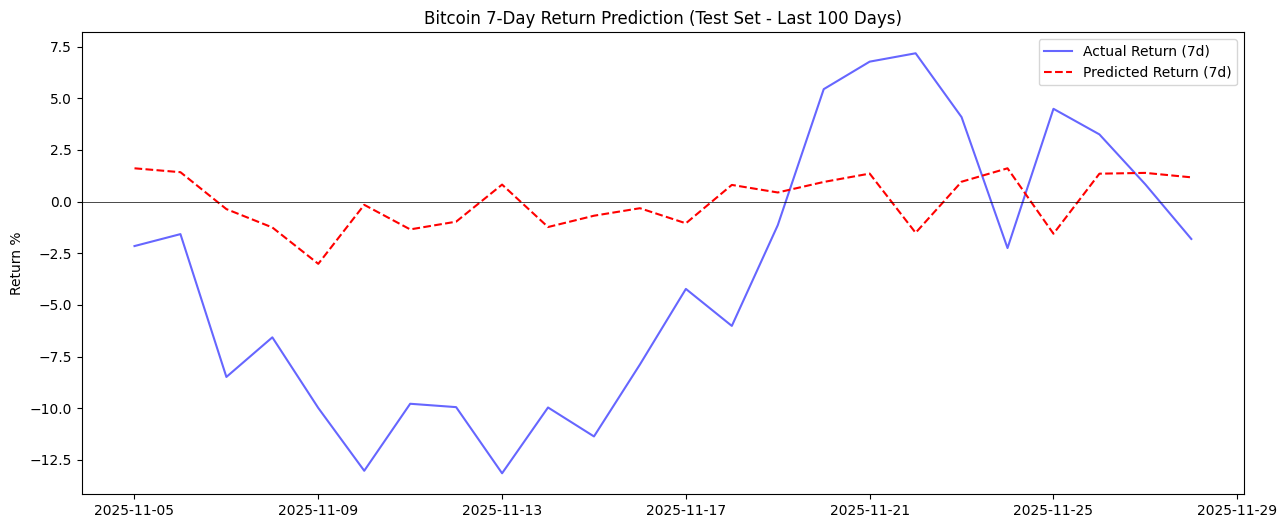

In [15]:
#Performance of the model

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Supposons que tu as déjà ton X et y propres
# X = tes features
# y = ton target (log return à 7 jours)

# --- Step 1: Time Series Split ---
# We generally take the first 80% of time for training, and the last 20% for testing.
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

# Crucial: We split by index order, NOT randomly
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training data: {len(X_train)} days")
print(f"Testing data: {len(X_test)} days")

# --- Step 2: Training ---
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100, 
    learning_rate=0.1,
    max_depth=5
)

model.fit(
    X_train, 
    y_train,
    # Optional: We can use the test set as eval_set to stop early if it overfits
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# --- Step 3: Evaluation ---
# We ask the model to predict on the Test set (data it has never seen during training)
preds_log = model.predict(X_test)

# Convert log returns back to percentage for human interpretation
# Formula: (exp(log_return) - 1) * 100
preds_pct = (np.exp(preds_log) - 1) * 100
actual_pct = (np.exp(y_test) - 1) * 100

# Calculate Error Metrics
mae = mean_absolute_error(actual_pct, preds_pct)
rmse = np.sqrt(mean_squared_error(actual_pct, preds_pct))

print(f"\n--- Performance Report ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}%")
# Interpretation: On average, the model is off by {mae}% regarding the weekly return.

# --- Step 4: Visualization ---
plt.figure(figsize=(15, 6))

# Plotting the last 100 days of the test set for clarity
# (Plotting everything can be messy)
limit = 100 

plt.plot(y_test.index[-limit:], actual_pct[-limit:], label='Actual Return (7d)', color='blue', alpha=0.6)
plt.plot(y_test.index[-limit:], preds_pct[-limit:], label='Predicted Return (7d)', color='red', linestyle='--')

plt.title(f"Bitcoin 7-Day Return Prediction (Test Set - Last {limit} Days)")
plt.ylabel("Return %")
plt.axhline(0, color='black', linewidth=0.5) # Zero line
plt.legend()
plt.show()